#Sentiment Analysis Deep Learning - LSTM & Dense 

In this notebook Sentiment Analysis is done for the Disneyland reviews dataset building a Deep Learning model with Keras framework.

To build the model the reviews need to be preprocessed and then tokenized into a word embedding vector that is then send as an input to the net. The model is building one LSTM and one Dense layer.

The model is trained using training and validation sets and then predict is executed for the test set. Also, a prediction is done for the full Disneyland review dataset.

**Import libraries**

In [32]:
#Load the libraries
import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.callbacks import EarlyStopping

**Load the Disneyland reviews dataset**

In [33]:
# read data from csv
disneyland_data=pd.read_csv('DisneylandReviews.csv', encoding="cp1252")
print(disneyland_data.shape)
disneyland_data.head(10)

(42656, 6)


,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
5,670591897,3,2019-4,Singapore,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong
6,670585330,5,2019-4,India,Great place! Your day will go by and you won't...,Disneyland_HongKong
7,670574142,3,2019-3,Malaysia,Think of it as an intro to Disney magic for th...,Disneyland_HongKong
8,670571027,2,2019-4,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong
9,670570869,5,2019-3,India,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong


**Positive/Negative split**

In [34]:
# assign positive label (1) for ratings from 1 to 3 and negative label (0) for ratings 1 and 2
disneyland_data["Sentiment"] = disneyland_data["Rating"].apply(lambda score: "positive" if score >= 3 else "negative")
disneyland_data['Sentiment'] = disneyland_data['Sentiment'].map({'positive':1, 'negative':0})
sentiment_data = disneyland_data[["Review_Text", "Sentiment"]]

In [35]:
# sentiment count to see if the dataset is balanced or not
sentiment_data['Sentiment'].value_counts()

1    39030
0     3626
Name: Sentiment, dtype: int64

The dataset is not balanced, so let's take a random sample from the positive label reviews and create a balanced dataset. 

In [36]:
# select positive reviews
positive_data = sentiment_data[sentiment_data['Sentiment'] == 1]
# take a sample size 4000 from the positive reviews
positive_sample = positive_data.sample(4000, random_state=123)
# select negative reviews
negative_data = sentiment_data[sentiment_data['Sentiment'] == 0]

In [37]:
# create new balanced dataset
data = positive_sample.append(negative_data)
# shuffle the rows from the dataset
data = data.sample(frac=1, random_state=123).reset_index(drop=True)

In [38]:
data['Sentiment'].value_counts()

1    4000
0    3626
Name: Sentiment, dtype: int64

Now the dataset is balanced.

**Text preprocessing**

In [39]:
# function for removing special characters (characters that are not letters or numbers)
def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# function for removing extra blank spaces (when there is more than one blank just replace with one)
def remove_extra_blank_spaces(text):
  return re.sub(' +', ' ', text)

#Apply functions on review column
data['Review_Text'] = data['Review_Text'].apply(remove_special_characters)
data['Review_Text'] = data['Review_Text'].apply(remove_extra_blank_spaces)

In [40]:
MAX_FEATURES = 10000
MAX_LEN = 512
BATCH_SIZE = 32

tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(data['Review_Text'].values)

X = tokenizer.texts_to_sequences(data['Review_Text'].values)
X = pad_sequences(X, maxlen=MAX_LEN)

**Train/Test split**

In [41]:
# split the dataset (80% for the train data and 20% for test data)

X_train, X_test, y_train, y_test = train_test_split(X, data['Sentiment'], test_size=0.20, 
                                                    stratify=data['Sentiment'], random_state=432)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(6100, 512) (1526, 512)
(6100,) (1526,)


**Build the model**

In [42]:
model = Sequential()
model.add(Embedding(MAX_FEATURES, 128))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         1280000   
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,419,905
Trainable params: 1,419,905
Non-trainable params: 0
_________________________________________________________________


**Train the model**

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/10
153/153 [==============================] - 110s 701ms/step - loss: 0.5127 - acc: 0.7443 - val_loss: 0.4256 - val_acc: 0.8123
Epoch 2/10
153/153 [==============================] - 108s 705ms/step - loss: 0.2730 - acc: 0.8912 - val_loss: 0.4123 - val_acc: 0.8303
Epoch 3/10
153/153 [==============================] - 106s 694ms/step - loss: 0.1667 - acc: 0.9359 - val_loss: 0.4537 - val_acc: 0.8320
Epoch 4/10
153/153 [==============================] - 106s 691ms/step - loss: 0.1034 - acc: 0.9635 - val_loss: 0.5830 - val_acc: 0.8279
Epoch 5/10
153/153 [==============================] - 105s 688ms/step - loss: 0.0676 - acc: 0.9779 - val_loss: 0.7911 - val_acc: 0.8033


In [44]:
# save the model
model.save('lstm_sentiment_disney.h5')

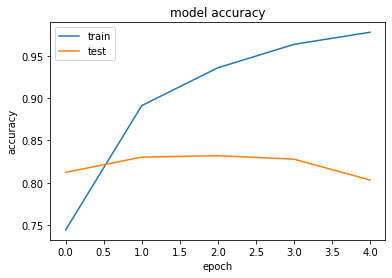

In [45]:
# summarize evolution for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

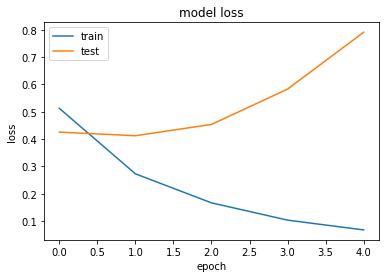

In [46]:
# summarize evolution for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Predict**

In [47]:
## Predict on test data
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)

In [48]:
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [49]:
# Classification report
model_report = classification_report(y_test, y_pred, target_names=['Positive','Negative'])
print(model_report)

              precision    recall  f1-score   support

    Positive       0.84      0.80      0.82       726
    Negative       0.83      0.86      0.85       800

    accuracy                           0.83      1526
   macro avg       0.84      0.83      0.83      1526
weighted avg       0.84      0.83      0.83      1526



Text(33.0, 0.5, 'Truth')

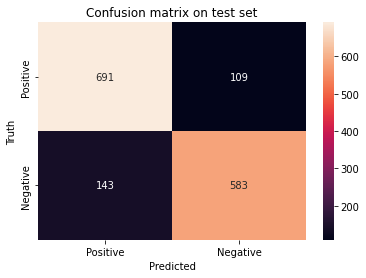

In [50]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1,0])

ax = sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix on test set')
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [56]:
## Predict on full dataset

# Apply functions on review column
disneyland_data['Review_Text'] = disneyland_data['Review_Text'].apply(remove_special_characters)
disneyland_data['Review_Text'] = disneyland_data['Review_Text'].apply(remove_extra_blank_spaces)

# Tokenize the reviews
tokenize_data = tokenizer.texts_to_sequences(disneyland_data['Review_Text'].values)
tokenize_data = pad_sequences(tokenize_data, maxlen=MAX_LEN)

In [58]:
# Execute predictions for the full dataset
full_pred = model.predict(tokenize_data, batch_size=BATCH_SIZE)

In [60]:
full_pred[full_pred >= 0.5] = 1
full_pred[full_pred < 0.5] = 0

full_real_sentiment = disneyland_data['Sentiment'].values

In [63]:
# Classification report
full_model_report = classification_report(full_real_sentiment, full_pred, target_names=['Positive','Negative'])
print(full_model_report)

              precision    recall  f1-score   support

    Positive       0.38      0.89      0.54      3626
    Negative       0.99      0.87      0.92     39030

    accuracy                           0.87     42656
   macro avg       0.69      0.88      0.73     42656
weighted avg       0.94      0.87      0.89     42656



Text(33.0, 0.5, 'Truth')

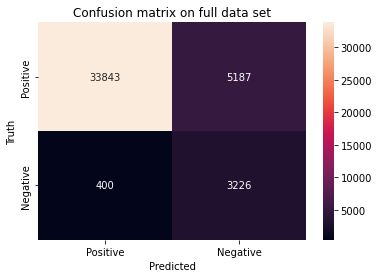

In [64]:
#confusion matrix
cm_full = confusion_matrix(full_real_sentiment, full_pred, labels=[1,0])

ax = sns.heatmap(cm_full, annot=True, fmt='d')
plt.title('Confusion matrix on full data set')
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [66]:
disneyland_data['Prediction'] = full_pred.astype('int')

disneyland_data.head(5)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Sentiment,Prediction
0,670772142,4,2019-4,Australia,If youve ever been to Disneyland anywhere youl...,Disneyland_HongKong,1,1
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,1,0
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid when...,Disneyland_HongKong,1,1
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park Unfortun...,Disneyland_HongKong,1,1
4,670607296,4,2019-4,United Kingdom,the location is not in the city took around 1 ...,Disneyland_HongKong,1,1


In [67]:
disneyland_data.to_csv('full_dataset_predictions.csv', sep=';', index=False)

In [71]:
disneyland_data.groupby(['Rating', 'Prediction']).count()['Review_ID']

Rating  Prediction
1       0              1404
        1                95
2       0              1822
        1               305
3       0              2247
        1              2862
4       0              1584
        1              9191
5       0              1356
        1             21790
Name: Review_ID, dtype: int64

In [72]:
disneyland_data.groupby(['Rating', 'Sentiment']).count()['Review_ID']

Rating  Sentiment
1       0             1499
2       0             2127
3       1             5109
4       1            10775
5       1            23146
Name: Review_ID, dtype: int64